# Stock Market Prediction
***
## Table of Contents

***

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import date
from torch import nn
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict
from numpy.typing import NDArray
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## 1. Introduction


## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

However, during the training process, I encountered several issues with LSTM networks on the MPS backend (e.g., error metrics became substantially higher compared to the CPU, etc.). Therefore, the CPU will be used throughout this project for '*safety*'.

**Reference**:
- [Training results from using MPS backend are poor compared to CPU and CUDA](https://github.com/pytorch/pytorch/issues/109457)
- [MPS backend produces bad training results in comparison to other backends](https://github.com/pytorch/pytorch/issues/92615)
- [Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)](https://github.com/pytorch/pytorch/issues/145374)

In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device = torch.device("cpu")  # For Mac, safer device use
device

device(type='cpu')

## 3. Loading Dataset
This project will use yfinance API to fetch financial data from Yahoo! Finance. The default DataFrame has a two-level column index: `(column name, ticker)`, so the second level will be removed.

In [6]:
TICKER = "AAPL"  # Apple Inc. stock data
START_DATE = "2015-01-01"
END_DATE = date.today().strftime("%Y-%m-%d")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
df.columns = df.columns.droplevel(1)  # Drop the second level
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [7]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

Price           Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.288578  24.757332  23.848704  24.746224  212818400
2015-01-05  23.604334  24.137514  23.417722  24.057537  257142000
2015-01-06  23.606558  23.866483  23.244438  23.668762  263188400
2015-01-07  23.937571  24.037541  23.704304  23.815383  160423600
2015-01-08  24.857306  24.915067  24.148620  24.266365  237458000
Shape of the dataset: (2660, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2660 entries, 2015-01-02 to 2025-07-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2660 non-null   float64
 1   High    2660 non-null   float64
 2   Low     2660 non-null   float64
 3   Open    2660 non-null   float64
 4   Volume  2660 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 124.7 KB
None
Count of null values: 0
Price        Close         High          L

In [8]:
FEATURES = list(range(len(df.columns)))  # All features
TARGET_INDEX = 0
TRAIN_SPLIT_RATE = 0.9
SEQUENCE_LENGTH = 90  # 90 days
BATCH_SIZE = 128
HIDDEN_SIZE = 256
INPUT_SIZE = len(FEATURES)
OUTPUT_SIZE = 1
N_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 10

## 4. Exploratory Data Analysis

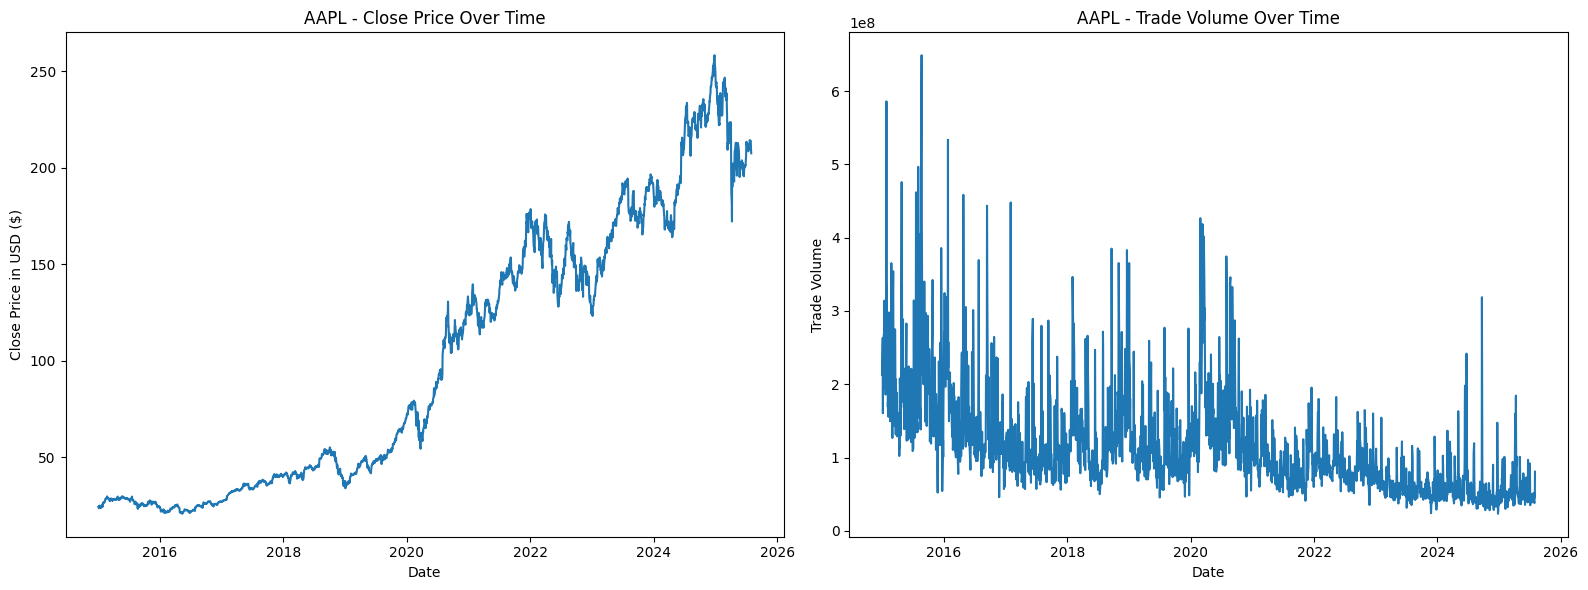

In [9]:
def plot_figures(df: pd.DataFrame, ticker: str) -> None:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    axes = axes.flatten()

    # 1st plot
    sns.lineplot(df, ax=axes[0], x=df.index, y="Close")
    axes[0].set_title(f"{ticker} - Close Price Over Time")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price in USD ($)")

    # 2nd plot
    sns.lineplot(df, ax=axes[1], x=df.index, y="Volume")
    axes[1].set_title(f"{ticker} - Trade Volume Over Time")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Trade Volume")

    plt.tight_layout()
    plt.show()


plot_figures(df, TICKER)


## 5. Sliding Window Sequences
The following function generates sliding window sequences and their corresponding targets from a multi-feature time-series array. This is a standard preprocessing step for models such as LSTM, GRU, or other neural networks that require sequence data as input.

<p align="center">
  <img src="https://www.researchgate.net/profile/Bernard-Benson/publication/341502672/figure/fig17/AS:998926190649344@1615173971540/Sliding-window-method-illustrated-with-an-example-sequence-of-numbers-from-1-through-10.ppm" width="550" alt="Sliding window method illustration">
</p>

*Figure: Visualisation of sliding window sequences. Image retrieved from [Forecasting Solar Cycle 25 Using Deep Neural Networks](https://www.researchgate.net/publication/341502672_Forecasting_Solar_Cycle_25_Using_Deep_Neural_Networks).*


In [10]:
def create_sequences(
    data: NDArray[np.float64],
    seq_length: int,
    feature_indices: List[int],
    target_index: int,
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Create sliding window sequences and targets for time series modelling.

    Args:
        data: Scaled data array of shape (n_samples, n_features_total).
        seq_length: Length of each window (timesteps per sequence).
        feature_indices: Indices of features to include in input.
        target_index: Index of the target variable.

    Returns:
        A tuple containing:
            - X: Input sequences, shape (n_sequences, seq_length, n_features).
            - y: Target values, shape (n_sequences, 1).

    Notes:
        Each target y[i] aligns with the index at position i+seq_length in the original data.
    """
    n_features, n_samples = len(feature_indices), len(data)
    X = np.zeros((n_samples - seq_length, seq_length, n_features))
    y = np.zeros(n_samples - seq_length)
    for i in range(seq_length, n_samples):
        X[i - seq_length] = data[i - seq_length : i, feature_indices]
        y[i - seq_length] = data[i, target_index]
    X = X.reshape(-1, seq_length, n_features)
    y = y.reshape(-1, 1)
    print(f"n_samples: {n_samples}\nX.shape: {X.shape} | y.shape: {y.shape}")
    return X, y

## 6. Preparing Dataloaders
1. Split data chronologically
2. Standardise data
3. Create sliding window sequences with targets for train/test datasets
4. Convert subsets to PyTorch tensors then to dataloaders
5. Return dataloaders & scalers (for inverse transformation later)

In [11]:
def prepare_dataloaders(
    df: pd.DataFrame,
    seq_length: int = 90,
    input_features: Optional[List[int]] = None,
    target_index: int = 0,
    train_split: float = 0.9,
    batch_size: int = 64,
) -> Tuple[DataLoader, DataLoader, MinMaxScaler, MinMaxScaler]:
    """
    Preprocess time-series data, generate DataLoaders.

    Args:
        df: DataFrame with features and target.
        seq_length: Length of each sequence window.
        input_features: Feature indices (default all features).
        target_index: Index of the target in the columns.
        train_split: Fraction for train/test split.
        batch_size: Batch size for loaders.

    Returns:
        A tuple containing:
            - train DataLoader,
            - test DataLoader,
            - fitted features scaler,
            - fitted target scaler.
    """
    print("Processing data...")
    if input_features is None:
        input_features = list(range(len(df.columns)))

    # Chronologically split data
    split_idx = int(len(df) * train_split)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    # Fit scalers on training set only
    features_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train_values = features_scaler.fit_transform(df_train.values)
    target_scaler.fit(df_train.iloc[:, target_index].values.reshape(-1, 1))

    test_values = features_scaler.transform(df_test.values)

    # Create train sequences
    X_train, y_train = create_sequences(
        train_values, seq_length, input_features, target_index
    )

    # Create test sequences
    X_test, y_test = create_sequences(
        test_values, seq_length, input_features, target_index
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Dataloaders are generated!")
    return (
        train_dataloader,
        test_dataloader,
        features_scaler,
        target_scaler,
    )

In [12]:
train_dataloader, test_dataloader, features_scaler, target_scaler = prepare_dataloaders(
    df=df,
    input_features=FEATURES,
    target_index=TARGET_INDEX,
    train_split=TRAIN_SPLIT_RATE,
    seq_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
)

Processing data...
n_samples: 2394
X.shape: (2304, 90, 5) | y.shape: (2304, 1)
n_samples: 266
X.shape: (176, 90, 5) | y.shape: (176, 1)
Dataloaders are generated!


In [13]:
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 18
Length of test_dataloader: 2


In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 90, 5]), torch.Size([128, 1]))

## 7. Recurrent Neural Network (RNN) Architectures
Recurrent Neural Networks (RNNs) are a class of neural networks designed specifically for sequential data, such as time series, text, or audio. Unlike feedforward neural networks, RNNs incorporate loops (recurrence), enabling them to retain and process information across different time steps. While RNNs are adept at modelling temporal dynamics, they are susceptible to two major issues:

- **Vanishing Gradients**:
    - If gradients become exceedingly small during backpropagation, they diminish as they are passed through many layers or time steps. This shrinkage prevents earlier layers or timesteps from learning effectively, causing the model to "forget" long-term dependencies and focus primarily on short-term information.

- **Exploding Gradients**:
    - If gradients grow excessively large during backpropagation, the resulting updates can become unstable and disproportionately large. This instability may cause the training process to diverge or exhibit erratic behaviour, hindering convergence.

Variants of RNNs, such as the Long Short-Term Memory (LSTM) and the Gated Recurrent Unit (GRU), are specifically designed to address these critical gradient-related issues. Through the use of gating mechanisms and improved memory control, these architectures allow more effective learning of long-term dependencies in sequential data.

### Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks are a specialised form of recurrent neural network (RNN) that employ gate-based mechanisms to regulate the flow of information across time steps, thereby enabling the learning of long-term temporal dependencies. Each LSTM cell contains three principal gates:

- **Input Gate** ($i_t$): Determines the extent to which new candidate information ($\tilde{c}_t$) is incorporated into the cell state.
- **Forget Gate** ($f_t$): Controls the proportion of previous cell state ($c_{t-1}$) information that is retained or discarded.
- **Output Gate** ($o_t$): Regulates how much of the current cell state ($c_t$) contributes to the cell’s output (hidden state $h_t$) at the current time step.

The gates typically apply a sigmoid activation function, yielding values in the range $[0, 1]$. These dynamically learned filters enable the network to selectively store, update, or reveal information at each time step, addressing the limitations of vanishing and exploding gradients encountered in conventional RNNs, particularly for long sequences.

LSTM Layer maintains two types of state tensors:
- **Hidden State**($h_t$): Contains the output features of the LSTM cell at each time step.
- **Cell State**($c_t$): Carries the internal memory of the LSTM cell, allowing it to preserve information over long sequences.

Both states are initialised with zeros (`init_hidden()`). After the initialisation, passing hidden states to the LSTM layer allows the model to preserve or manipulate internal states. At time step $t$, the parameteres are updates as:

$$
(h_t,c_t) = \text{LSTM}(x_t,(h_{t-1},c_{t-1}))
$$

The output of LSTM (`lstm_out`) has the shape of `[batch_size, seq_length, hidden_size]` due to `batch_first=True`. The final time step's output is represented as `lstm_out[:, -1, :]` for the whole sequence.